<a href="https://colab.research.google.com/github/jimuelceleste/system-modeling-notes/blob/main/EnE%20305%20-%20Adding_Stochastics_to_ASQ_SEIR_NLIR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

-0.0014391377417162295
0.0019104925661699084


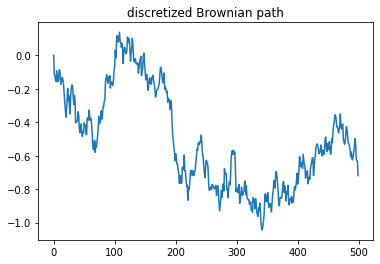

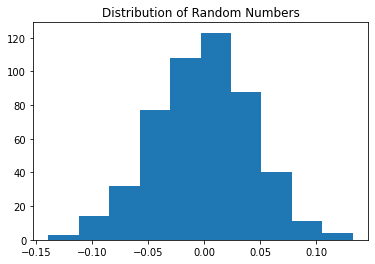

In [ ]:
# Notes on Brownian Motion

import random
import math 
import matplotlib.pyplot as plt
import numpy as np 

T = 1 
N = 500 
dt = T/N

dW = [0]*N
W = [0]*N 

mean = 0
variance = 1

for i in range(1, N):
    dW[i] = math.sqrt(dt) * random.normalvariate(mean, math.sqrt(variance))
    W[i] = W[i-1] + dW[i]

plt.plot(W)
plt.title("discretized Brownian path")

plt.figure()
plt.hist(dW)
plt.title("Distribution of Random Numbers")

print(np.average(dW))
print(np.var(dW))

Stochastic ASQ-SEIR-NLIR

In [ ]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import math 

def get_asq_seir_nlir(beta, sigma, gamma, q, u, alpha, epsilon, rho):
    def asq_seir_nlir(y, t):
        s,e,i,r = y
        n = sum(y)
        return np.array([
            (-beta * q * s * i / n) / ((1 + alpha * s / n) * (1 + epsilon * i / n)), 
            ((beta * q * s * i / n) / ((1 + alpha * s / n) * (1 + epsilon * i / n))) - sigma * u * e, 
            sigma * u * e - gamma * i, 
            gamma * i
        ])
    def stochastic_term(y, t):
        s,e,i,r = y 
        n = sum(y)
        return np.array([
            -rho * beta * s * i / n, 
            rho * beta * s * i / n, 
            0, 
            0
        ])
    return asq_seir_nlir, stochastic_term

Euler Maruyama Method 

$X(\tau_j) = X(\tau_{j-1}) + \int_{\tau_{j-1}}^{\tau_j} f(X(s))ds + \int_{\tau_{j-1}}^{\tau_j} g(X(s))dW(s)$

$X_j = X_{j-1} + f(X_{j-1}) \Delta t + g(X_{j-1})(W(\tau_j)-W(\tau_{j-1})), j = 1, 2, ..., L$



In [ ]:
# Euler Maruyama Method 
from random import normalvariate

def dW(dt, t):
    if t == 0: 
      r = 0
    else:
      r = math.sqrt(dt) * normalvariate(mu=0, sigma=1)
    return r 

def euler_maruyama(f, g, dt, y0, t0):
    return y0 + f(y0, t0) * dt + g(y0, t0) * dW(dt, t)

In [ ]:
# PH population 2022: https://www.worldometers.info/world-population/philippines-population/
ph_pop = 112041552
# Fully vaccinated: https://doh.gov.ph/covid19-vaccination-dashboard 
fully_vaccinated = 63992620
estimated_efficacy = 0.77 # Computations of Nico and Thomas as of January 2022
estimated_immune = fully_vaccinated * estimated_efficacy
# COVID cases as of March , 2022: https://doh.gov.ph/covid19tracker
active = 45339
dead = 58023
recovered = 3570355
# SEIR
i0 = active
e0 = active * 0.5 # assumption
r0 = recovered + dead + estimated_immune
s0 = ph_pop - (e0 + i0 + r0)
y0 = np.array([s0, e0, i0, r0]) / ph_pop

# Parameters for PH as estimated by Gabriel Santos (2022)
beta = 2
sigma = 0.28
gamma = 0.33 
q = 0.2
u = 1
alpha = 0.13
epsilon = 0.7

# # QC SEIR from Minoza et al. (2020)
# s0 = 0.999998985
# e0 = 0.00001
# i0 = 0.0000001
# r0 = 0.00000005
# y0 = np.array([s0, e0, i0, r0])

# # Parameters for QC as estimated by Minoza et al. (2020)
# beta = 3.2
# sigma = 0.142857
# gamma = 0.33 
# q = 0.2
# u = 1
# alpha = 0.36
# epsilon = 0.10

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


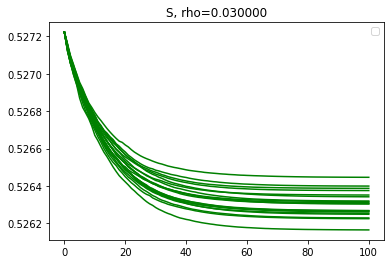

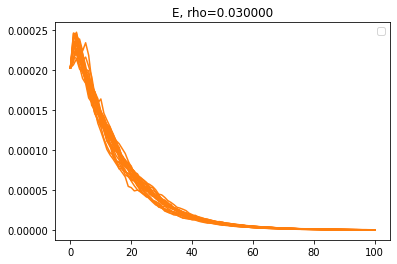

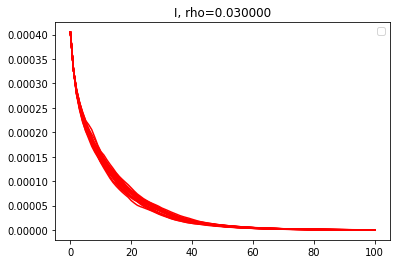

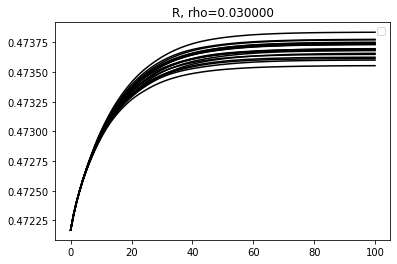

In [ ]:
T = 100 # Time Steps 
N = 100 # Mesh Points
dt = T/N

rho = 0.03
f, g = get_asq_seir_nlir(beta, sigma, gamma, q, u, alpha, epsilon, rho)

iterations = 20
results = []
for i in range(iterations):    
    seir = [y0]
    time = [0]
    y = y0
    t = 1

    while t <= T:
        y = euler_maruyama(f, g, dt, y, t)
        time.append(t)
        seir.append(y)
        t += dt
        
    seir = pd.DataFrame(seir, columns=["S","E","I","R"])
    results.append(seir)

colors={
    "S": "g", 
    "E": "C1", 
    "I": "r", 
    "R": "k"
}

for state in "SEIR":
    plt.figure(state)
    plt.title(state + ", "+ "rho=%f" % (rho))
    for i in range(iterations):
        plt.plot(time, results[i][state], color=colors[state])
    plt.legend()

References 

Higham, D.J. (2001) An algorithmic introduction to numerical simulation of stochastic differential equations. SIAM Review, 43 (3). pp. 525-546. ISSN 0036-1445

Zhang, Z., Zeb, A., Hussain, S. et al. “Dynamics of COVID-19 mathematical model with stochastic perturbation.” Advances in Continuous and Discrete Models, 451 (2020). 